## 库的导入

In [72]:
#导入库
from cylib.qmtdata.cyxtdata import xtdata  
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import seaborn as sns

## 股票

In [2]:
#获取数据
stock_list = [
    '159511.SZ', '159546.SZ', '159611.SZ', '159662.SZ',
    '159666.SZ', '159672.SZ', '159689.SZ', '159707.SZ', '159797.SZ',
    '159841.SZ', '159842.SZ', '159848.SZ', '159883.SZ', '159887.SZ',
    '159898.SZ', '159928.SZ', '159929.SZ', '159930.SZ', '159936.SZ',
    '159938.SZ', '159939.SZ', '159944.SZ', '159945.SZ', '159996.SZ',
    '510200.SH', '510230.SH', '510630.SH', '510660.SH', '512000.SH',
    '512010.SH', '512200.SH', '512330.SH', '512400.SH', '512480.SH',
    '512570.SH', '512600.SH', '512700.SH', '512730.SH', '512800.SH',
    '512820.SH', '512880.SH', '512900.SH', '515010.SH', '515020.SH',
    '515060.SH', '515220.SH', '515280.SH', '515290.SH', '515560.SH',
    '515850.SH', '516200.SH', '516210.SH', '516310.SH', '516900.SH',
    '516970.SH', '517380.SH', '517990.SH', '560090.SH', '560580.SH',
    '560680.SH', '560880.SH', '561010.SH', '561120.SH', '561360.SH',
    '561560.SH', '561700.SH', '562350.SH', '562600.SH'
]

stdata = xtdata.get_market_data_ex(
    field_list=['close'], stock_list=stock_list, period='1d',
    start_time='20223216', end_time='20240306', count=-1,
    dividend_type='front', fill_data=True
)
#print(stdata)
print(type(stdata))

<class 'dict'>


In [3]:
#矩阵化，行日期，列股票
stocks = list(stdata.keys())
dates = list(stdata[stocks[0]].index)
#create np.data 0
data_array = np.zeros((len(dates), len(stocks)))
#fill the value
for i, stock in enumerate(stocks):
    data_array[:, i] = stdata[stock]['close'].values
df_st = pd.DataFrame(data_array, index=[str(date) for date in dates], columns=stocks)
df_st.fillna(0, inplace=True)
#print(df_st)

In [4]:
#计算同比和环比

#同比
def calculate_yoy(df):
    yoy_df = df.copy()
    
    for stock in df.columns:
        last_year_values = df[stock].shift(12)
        yoy_df[stock] = (df[stock] - last_year_values) / last_year_values

    return yoy_df

#环比
def calculate_mom(df):
    mom_df = df.copy()
    
    for stock in df.columns:
        last_month_values = df[stock].shift(1)
        mom_df[stock] = (df[stock] - last_month_values) / last_month_values

    return mom_df

In [5]:
#同比
styoy_0 = calculate_yoy(df_st)
styoy = styoy_0.fillna(0)
#print(yoy)

#环比
stmom_0 = calculate_mom(df_st)
stmom = stmom_0.fillna(0)
#print(mom)

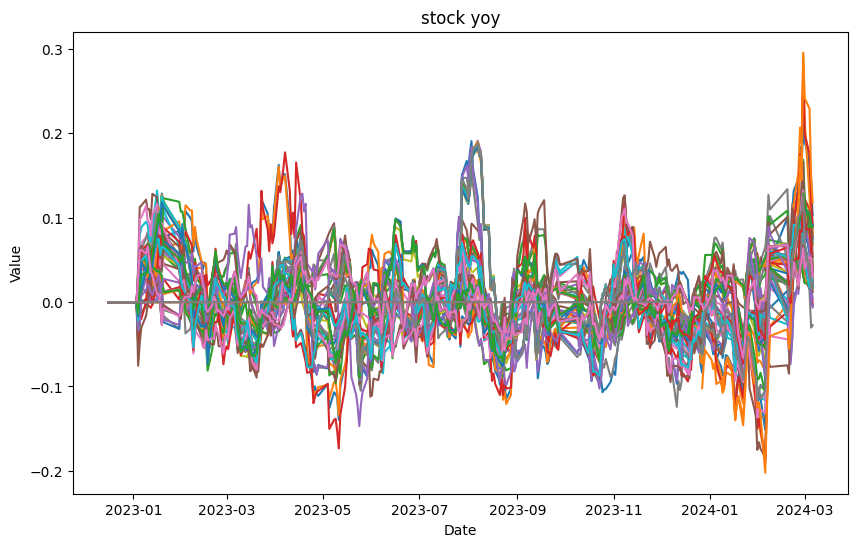

In [6]:
#股票指数同比序列图
styoy.index = pd.to_datetime(styoy.index)

plt.figure(figsize=(10, 6))

for column in styoy.columns:
    dates = styoy.index
    values = styoy[column]
    plt.plot(dates, values, label=column, linestyle='-', marker=None)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('stock yoy')
#plt.legend(loc='best')
plt.show()

In [18]:
#pca股票同比

data_array = styoy.to_numpy()
#NaN,inf->0
data_array[np.isnan(data_array)] = 0
data_array[np.isinf(data_array)] = 0
pca_styoy = PCA(n_components=6)
pca_styoy.fit(data_array)
transformed_data = pca_styoy.transform(data_array)
#DataFrame
pca_styoy_df = pd.DataFrame(transformed_data, index=styoy.index, columns=['PCA1_styoy', 'PCA2_styoy', 'PCA3_styoy', 'PCA4_styoy', 'PCA5_styoy', 'PCA6_styoy'])

#print(pca_styoy_df)

In [21]:
#pca股票环比

data_array = stmom.to_numpy()
#NaN,inf->0
data_array[np.isnan(data_array)] = 0
data_array[np.isinf(data_array)] = 0
pca_stmom = PCA(n_components=6)
pca_stmom.fit(data_array)
transformed_data = pca_stmom.transform(data_array)
#DataFrame
pca_stmom_df = pd.DataFrame(transformed_data, index=stmom.index, columns=['PCA1_stmom', 'PCA2_stmom', 'PCA3_stmom', 'PCA4_stmom', 'PCA5_stmom', 'PCA6_stmom'])

#print(pca_styoy_df)

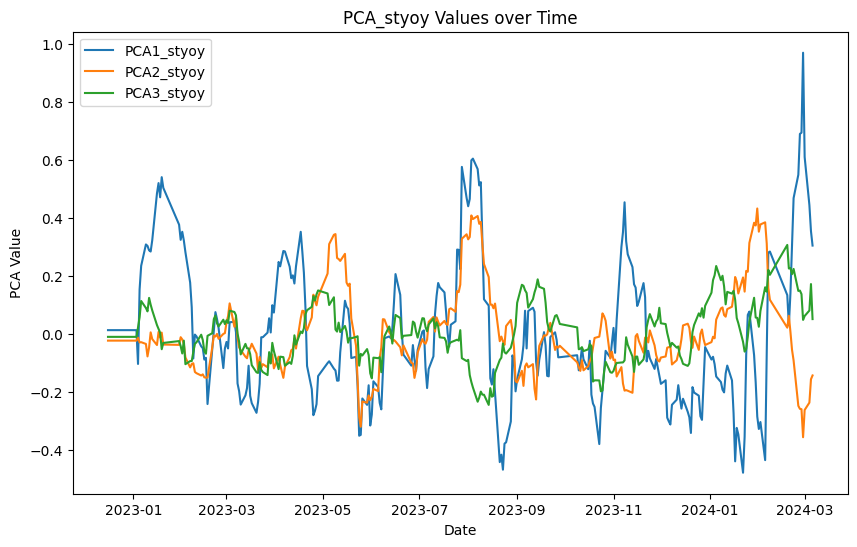

In [20]:
#pca股票同比图

plt.figure(figsize=(10, 6))
#参数
for column in pca_styoy_df.columns[:3]:
    dates = pca_styoy_df.index
    values = pca_styoy_df[column]
    
    plt.plot(dates, values, label=column, linestyle='-', marker=None)

plt.xlabel('Date')
plt.ylabel('PCA Value')
plt.title('PCA_styoy Values over Time')
plt.legend(loc='best')
plt.show()

In [36]:
#解释度和权重

# 解释度
explained_styoy = pca_styoy.explained_variance_ratio_[:6]
explained_sum_styoy = np.sum(pca_styoy.explained_variance_ratio_[:6])
print("股票指数同比序列前六个主成分解释度:", explained_styoy)
print("合计:", explained_sum_styoy)

explained_stmom = pca_stmom.explained_variance_ratio_[:6]
explained_sum_stmom = np.sum(pca_stmom.explained_variance_ratio_[:6])
print("股票指数环比序列前六个主成分解释度:", explained_stmom)
print("合计:", explained_sum_stmom)

#权重
components_styoy = pca_styoy.components_[:3]
weights_styoy = (pd.DataFrame(components_styoy, columns=styoy.columns, index=['PC1_styoy', 'PC2_styoy', 'PC3_styoy'])).T
print("股票指数同比序列前三个主成分权重:")
print(weights_styoy)

components_stmom = pca_stmom.components_[:3]
weights_stmom = (pd.DataFrame(components_stmom, columns=stmom.columns, index=['PC1_stmom', 'PC2_stmom', 'PC3_stmom'])).T
print("股票指数环比序列前三个主成分权重:")
print(weights_stmom)

股票指数同比序列前六个主成分解释度: [0.50653091 0.18022011 0.08574708 0.04433083 0.04091617 0.02654579]
合计: 0.8842909007838835
股票指数环比序列前六个主成分解释度: [0.49116278 0.12730308 0.07659129 0.05994272 0.04767409 0.03808373]
合计: 0.8407576889568353
股票指数同比序列前三个主成分权重:
           PC1_styoy  PC2_styoy  PC3_styoy
159511.SZ   0.093513  -0.071014   0.070212
159546.SZ   0.107808  -0.164252  -0.062089
159611.SZ   0.032651   0.005581   0.119416
159662.SZ   0.072714   0.015671   0.056484
159666.SZ   0.068654   0.007745   0.055163
...              ...        ...        ...
561360.SH   0.038978  -0.032377   0.071422
561560.SH   0.031351   0.006502   0.112259
561700.SH   0.030289   0.004047   0.111259
562350.SH   0.029781   0.006881   0.112178
562600.SH   0.047559  -0.085230   0.004538

[68 rows x 3 columns]
股票指数环比序列前三个主成分权重:
           PC1_stmom  PC2_stmom  PC3_stmom
159511.SZ   0.083288   0.107520   0.044783
159546.SZ   0.082923   0.146574   0.063107
159611.SZ   0.052676  -0.019361  -0.092032
159662.SZ   0.093618  -0.011922  

## 其他资产（同比）

In [42]:
#商品

In [40]:
#1.数据处理
goods_list = [
    '159830.SZ', '159831.SZ', '159834.SZ', '159934.SZ', '159937.SZ',
    '159980.SZ', '159981.SZ', '159985.SZ', '518600.SH', '518660.SH',
    '518680.SH', '518800.SH', '518850.SH', '518860.SH', '518880.SH',
    '518890.SH', '160723.SZ', '160216.SZ', '160719.SZ', '164701.SZ',
    '165513.SZ', '501018.SH'
]
gddata = xtdata.get_market_data_ex(
    field_list=['close'], stock_list=goods_list, period='1d',
    start_time='20223216', end_time='20240306', count=-1,
    dividend_type='front', fill_data=True
)

print(type(gddata))


#2.矩阵化，行日期，列股票
stocks = list(gddata.keys())
dates = list(gddata[stocks[0]].index)
#create np.data 0
data_array = np.zeros((len(dates), len(stocks)))
#fill the value
for i, stock in enumerate(stocks):
    data_array[:, i] = gddata[stock]['close'].values
df_gd = pd.DataFrame(data_array, index=[str(date) for date in dates], columns=stocks)
df_gd.fillna(0, inplace=True)


#3.同比
gdyoy_0 = calculate_yoy(df_gd)
gdyoy = gdyoy_0.fillna(0)


#4.pca

data_array = gdyoy.to_numpy()
#NaN,inf->0
data_array[np.isnan(data_array)] = 0
data_array[np.isinf(data_array)] = 0
pca_gdyoy = PCA(n_components=6)
pca_gdyoy.fit(data_array)
transformed_data = pca_gdyoy.transform(data_array)
#DataFrame
pca_gdyoy_df = pd.DataFrame(transformed_data, index=styoy.index, columns=['PCA1_gdyoy', 'PCA2_gdyoy', 'PCA3_gdyoy', 'PCA4_gdyoy', 'PCA5_gdyoy', 'PCA6_gdyoy'])

#print(pca_gdyoy_df)

<class 'dict'>


In [43]:
#债券

In [45]:
#1.数据处理
debt_list = [
    '159649.SZ', '159650.SZ', '159651.SZ', '159816.SZ', '159972.SZ',
    '511010.SH', '511020.SH', '511030.SH', '511060.SH', '511090.SH',
    '511100.SH', '511130.SH', '511180.SH', '511220.SH', '511260.SH',
    '511270.SH', '511360.SH', '511380.SH', '511520.SH', '511580.SH'
]
dedata = xtdata.get_market_data_ex(
    field_list=['close'], stock_list=debt_list, period='1d',
    start_time='20223216', end_time='20240306', count=-1,
    dividend_type='front', fill_data=True
)

print(type(dedata))


#2.矩阵化，行日期，列股票
stocks = list(dedata.keys())
dates = list(dedata[stocks[0]].index)
#create np.data 0
data_array = np.zeros((len(dates), len(stocks)))
#fill the value
for i, stock in enumerate(stocks):
    data_array[:, i] = dedata[stock]['close'].values
df_de = pd.DataFrame(data_array, index=[str(date) for date in dates], columns=stocks)
df_de.fillna(0, inplace=True)


#3.同比
deyoy_0 = calculate_yoy(df_de)
deyoy = deyoy_0.fillna(0)


#4.pca

data_array = deyoy.to_numpy()
#NaN,inf->0
data_array[np.isnan(data_array)] = 0
data_array[np.isinf(data_array)] = 0
pca_deyoy = PCA(n_components=6)
pca_deyoy.fit(data_array)
transformed_data = pca_deyoy.transform(data_array)
#DataFrame
pca_deyoy_df = pd.DataFrame(transformed_data, index=deyoy.index, columns=['PCA1_deyoy', 'PCA2_deyoy', 'PCA3_deyoy', 'PCA4_deyoy', 'PCA5_deyoy', 'PCA6_deyoy'])

#print(pca_deyoy_df)

<class 'dict'>


In [ ]:
#跨境

In [66]:
#1.数据处理
cross_list = [
    '159501.SZ', '159513.SZ', '159577.SZ', '159612.SZ', '159632.SZ',
    '159655.SZ', '159659.SZ', '159660.SZ', '159696.SZ', '159711.SZ',
    '159712.SZ', '159866.SZ', '159920.SZ', '159941.SZ', '513000.SH',
    '513030.SH', '513080.SH', '513100.SH', '513110.SH', '513300.SH',
    '513390.SH', '513500.SH', '513520.SH', '513550.SH', '513600.SH',
    '513650.SH', '513660.SH', '513850.SH', '513870.SH', '513880.SH',
    '513900.SH'
]
crdata = xtdata.get_market_data_ex(
    field_list=['close'], stock_list=cross_list, period='1d',
    start_time='20223216', end_time='20240306', count=-1,
    dividend_type='front', fill_data=True
)

print(type(crdata))


#2.矩阵化，行日期，列股票
stocks = list(crdata.keys())
dates = list(crdata[stocks[0]].index)
#create np.data 0
data_array = np.zeros((len(dates), len(stocks)))
#fill the value
for i, stock in enumerate(stocks):
    data_array[:, i] = crdata[stock]['close'].values
cr_de = pd.DataFrame(data_array, index=[str(date) for date in dates], columns=stocks)
cr_de.fillna(0, inplace=True)


#3.同比
cryoy_0 = calculate_yoy(cr_de)
cryoy = cryoy_0.fillna(0)


#4.pca

data_array = cryoy.to_numpy()
#NaN,inf->0
data_array[np.isnan(data_array)] = 0
data_array[np.isinf(data_array)] = 0
pca_cryoy = PCA(n_components=6)
pca_cryoy.fit(data_array)
transformed_data = pca_cryoy.transform(data_array)
#DataFrame
pca_cryoy_df = pd.DataFrame(transformed_data, index=cryoy.index, columns=['PCA1_cryoy', 'PCA2_cryoy', 'PCA3_cryoy', 'PCA4_cryoy', 'PCA5_cryoy', 'PCA6_cryoy'])

#print(pca_cryoy_df)

<class 'dict'>


<Figure size 1000x600 with 0 Axes>

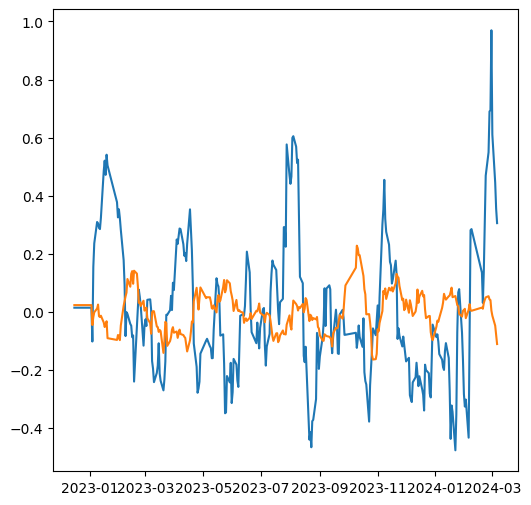

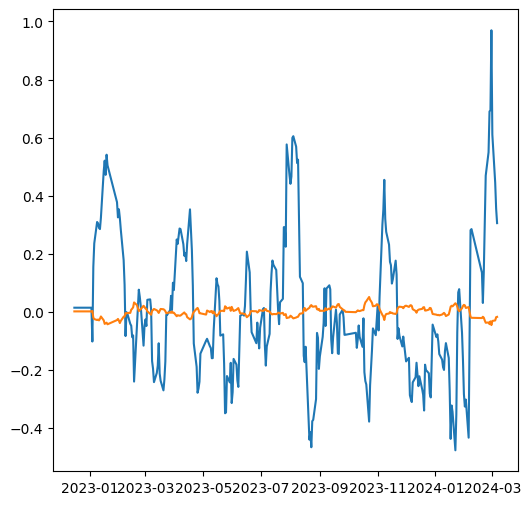

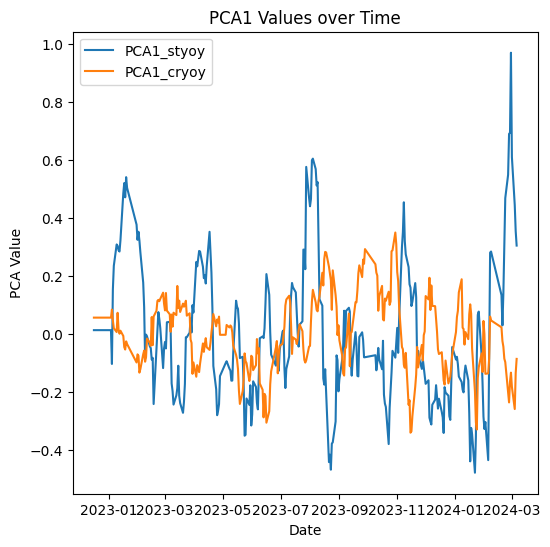

In [71]:
#所有资产pca走势图

plt.figure(figsize=(10, 6))
#参数
dates = pca_styoy_df.index
values_st = pca_styoy_df['PCA1_styoy']
values_gd = pca_gdyoy_df['PCA1_gdyoy']
values_de = pca_deyoy_df['PCA1_deyoy']
values_cr = pca_cryoy_df['PCA1_cryoy']
plt.figure(figsize=(6, 6))
plt.plot(dates, values_st, label='PCA1_styoy', linestyle='-', marker=None)
plt.plot(dates, values_gd, label='PCA1_gdyoy', linestyle='-', marker=None)
plt.figure(figsize=(6, 6))
plt.plot(dates, values_st, label='PCA1_styoy', linestyle='-', marker=None)
plt.plot(dates, values_de, label='PCA1_deyoy', linestyle='-', marker=None)
plt.figure(figsize=(6, 6))
plt.plot(dates, values_st, label='PCA1_styoy', linestyle='-', marker=None)
plt.plot(dates, values_cr, label='PCA1_cryoy', linestyle='-', marker=None)

plt.xlabel('Date')
plt.ylabel('PCA Value')
plt.title('PCA1 Values over Time')
plt.legend(loc='best')
plt.show()

## 各类资产前三个主成分相关系数矩阵

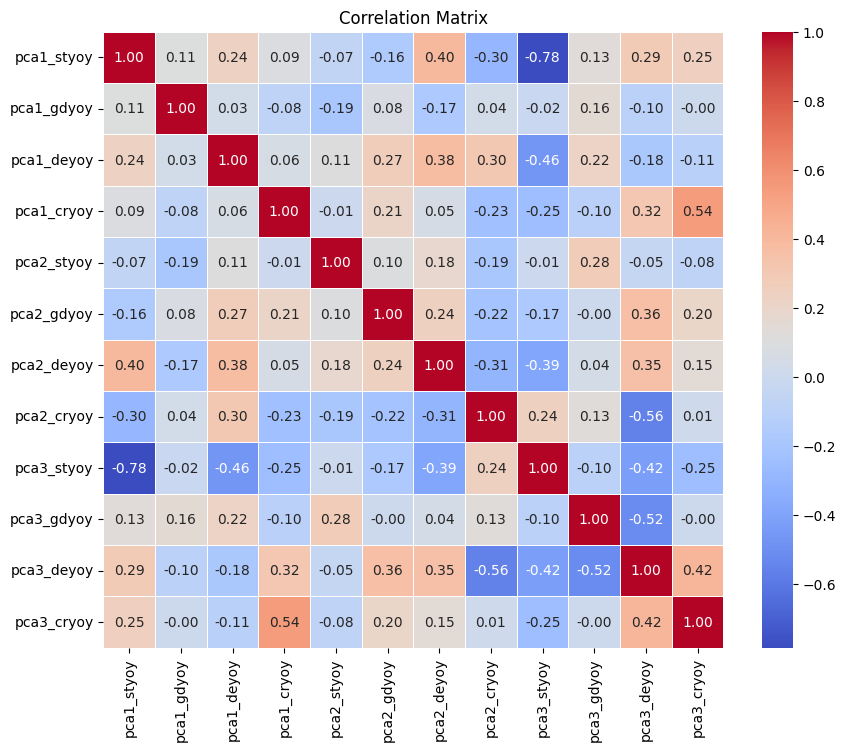

In [80]:
#各类资产前三个主成分相关系数矩阵

import seaborn as sns
import matplotlib.pyplot as plt

pca_components_dict = {
    'styoy': pca_styoy.components_[:3],
    'gdyoy': pca_gdyoy.components_[:3],
    'deyoy': pca_deyoy.components_[:3],
    'cryoy': pca_cryoy.components_[:3]
}

corr_matrices = {}
for asset, pca_components in pca_components_dict.items():
    pca_corr_matrix = pd.DataFrame(pca_components.T, columns=[f'{asset}_PC1', f'{asset}_PC2', f'{asset}_PC3'])
    corr_matrices[asset] = pca_corr_matrix

full_corr_matrix = pd.DataFrame()

col_order = [f'pca{i}_{asset}' for i in range(1, 4) for asset in ['styoy', 'gdyoy', 'deyoy', 'cryoy']]
for asset, corr_matrix in corr_matrices.items():
    corr_matrix.columns = [f'pca{i}_{asset}' for i in range(1, 4)]
    full_corr_matrix = pd.concat([full_corr_matrix, corr_matrix], axis=1)

full_corr_matrix = full_corr_matrix.reindex(columns=col_order)

# 绘制热图
plt.figure(figsize=(10, 8))
sns.heatmap(full_corr_matrix.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


## 市场因子

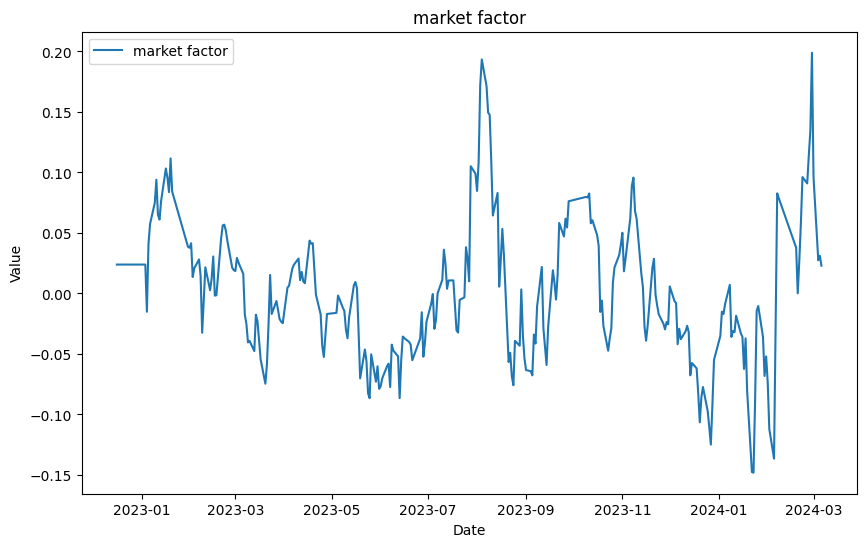

In [86]:
#各个资产pca1等权组合
market_factor = (pca_styoy_df['PCA1_styoy'] + pca_gdyoy_df['PCA1_gdyoy'] + pca_deyoy_df['PCA1_deyoy'] + pca_cryoy_df['PCA1_cryoy'])/4

#pic
dates = market_factor.index
values = market_factor

plt.figure(figsize=(10, 6))
plt.plot(dates, values, label='market factor', linestyle='-', marker=None)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('market factor')
plt.legend(loc='best')
plt.show()